In [106]:
# https://platform.olimpiada-ai.ro/en/problems/84

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

In [107]:
train = pd.read_csv('/kaggle/input/petronel/dataset_train.csv')
test = pd.read_csv('/kaggle/input/petronel/dataset_eval.csv')

train.shape, test.shape

((229, 10), (100, 9))

In [108]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229 entries, 0 to 228
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Activity ID         229 non-null    int64  
 1   Activity Date       229 non-null    object 
 2   Distance            229 non-null    float64
 3   Elapsed Time        229 non-null    int64  
 4   Moving Time         229 non-null    float64
 5   Starting Latitude   229 non-null    float64
 6   Starting Longitude  229 non-null    float64
 7   Finish Latitude     229 non-null    float64
 8   Finish Longitude    229 non-null    float64
 9   Label               229 non-null    object 
dtypes: float64(6), int64(2), object(2)
memory usage: 18.0+ KB


In [109]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Activity ID         100 non-null    int64  
 1   Activity Date       100 non-null    object 
 2   Distance            100 non-null    float64
 3   Elapsed Time        100 non-null    int64  
 4   Moving Time         100 non-null    float64
 5   Starting Latitude   100 non-null    float64
 6   Starting Longitude  100 non-null    float64
 7   Finish Latitude     100 non-null    float64
 8   Finish Longitude    100 non-null    float64
dtypes: float64(6), int64(2), object(1)
memory usage: 7.2+ KB


In [110]:
train.head()

,Activity ID,Activity Date,Distance,Elapsed Time,Moving Time,Starting Latitude,Starting Longitude,Finish Latitude,Finish Longitude,Label
0,15561313085,"Aug 23, 2025, 4:55:36 PM",11.19,4332,2900.0,44.386880,38.845067,44.386660,38.845216,PURE_LEISURE
1,16321410676,"Nov 1, 2025, 10:58:07 AM",10.51,9262,2724.0,44.387036,38.843094,44.403151,38.781384,PURE_LEISURE
2,12867426384,"Nov 10, 2024, 10:18:40 AM",19.10,8214,5130.0,44.386809,38.845026,44.386922,38.845124,PURE_LEISURE
3,11903829345,"Jul 16, 2024, 4:02:30 PM",15.31,5822,4259.0,44.387054,38.811028,44.386923,38.845091,LEISURELY_COMMUTE
4,14323523606,"Apr 29, 2025, 3:48:33 PM",4.46,1383,1194.0,44.387410,38.811053,44.386965,38.845283,COMMUTE


In [111]:
def process_df(df):
    df['kmh'] = df['Distance'] / (df['Moving Time'] / 3600)
    df['Activity Date'] = pd.to_datetime(df['Activity Date'])
    df['hour'] = df['Activity Date'].dt.hour
    df['minute'] = df['Activity Date'].dt.minute
    df['second'] = df['Activity Date'].dt.second
    df['month'] = df['Activity Date'].dt.month
    df['dayofyear'] = df['Activity Date'].dt.dayofyear
    df['season'] = ((df['Activity Date'].dt.month % 12) // 3).astype(str)
    df['elapsed-moving'] = df['Elapsed Time'] - df['Moving Time']
    df['diff_latitude'] = df['Finish Latitude'] - df['Starting Latitude']
    df['diff_longitude'] = df['Finish Longitude'] - df['Starting Longitude']
    return df

train = process_df(train)
test = process_df(test)

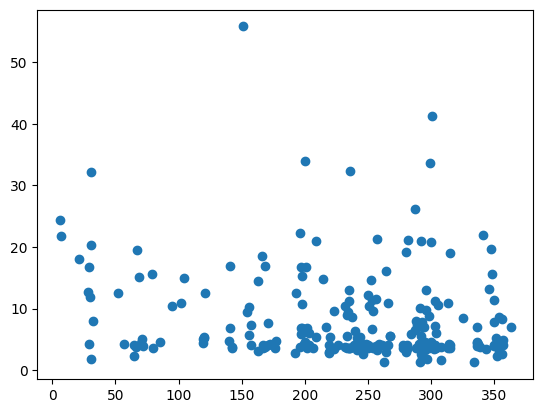

In [112]:
plt.scatter(train['dayofyear'], train['Distance'])
plt.show()

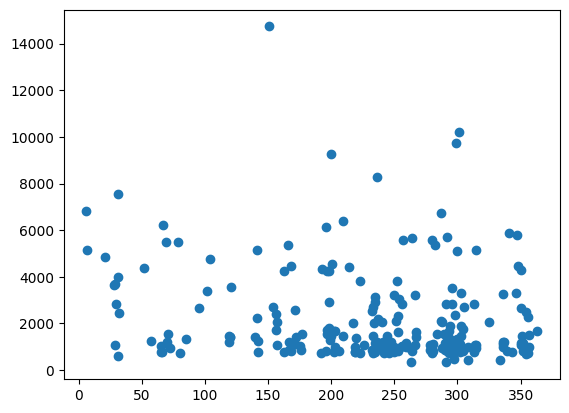

In [113]:
plt.scatter(train['dayofyear'], train['Moving Time'])
plt.show()

In [114]:
from sklearn.model_selection import train_test_split
from catboost import Pool

features = [c for c in train.columns if c not in ['Activity ID', 'Label']]
cat_features = [c for c in train.select_dtypes('object').columns if c in features]
target_col = 'Label'

X, y = train[features], train[target_col]
X_test = test[features]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=0.1, random_state=42)

train_pool = Pool(X_train, y_train, cat_features=cat_features)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features)

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((206, 18), (23, 18), (206,), (23,))

In [115]:
from catboost import CatBoostClassifier

params = {
    'iterations': 400,
    'loss_function': 'MultiClass',
    'eval_metric': 'Accuracy',
    'metric_period': 100,
    'random_state': 42,
    'max_depth': 4
}

model = CatBoostClassifier(**params)

model.fit(train_pool, eval_set=valid_pool)

Learning rate set to 0.148463
0:	learn: 0.9126214	test: 0.9130435	best: 0.9130435 (0)	total: 2.05ms	remaining: 817ms
100:	learn: 1.0000000	test: 0.9130435	best: 0.9130435 (0)	total: 172ms	remaining: 508ms
200:	learn: 1.0000000	test: 0.9130435	best: 0.9130435 (0)	total: 338ms	remaining: 335ms
300:	learn: 1.0000000	test: 0.9565217	best: 0.9565217 (300)	total: 504ms	remaining: 166ms
399:	learn: 1.0000000	test: 0.9565217	best: 0.9565217 (300)	total: 668ms	remaining: 0us

bestTest = 0.9565217391
bestIteration = 300

Shrink model to first 301 iterations.


In [116]:
y_pred = model.predict(X_test).squeeze()


subm = {
    'subtaskID': [2] * len(test),
    'Answer1': test['Activity ID'].tolist(),
    'Answer2': y_pred.tolist()
}

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
speeds = train.groupby('month')['kmh'].mean().sort_index().values

for m, s in zip(months, speeds):
    subm['subtaskID'].append(1)
    subm['Answer1'].append(m)
    subm['Answer2'].append(s)

subm = pd.DataFrame(subm)

subm.to_csv("submission.csv", index=False)

subm.head()

,subtaskID,Answer1,Answer2
0,2,14319106971,COMMUTE
1,2,12589508252,PURE_LEISURE
2,2,11908121839,COMMUTE
3,2,16687631914,PURE_LEISURE
4,2,12212251514,PURE_LEISURE
